<a href="https://colab.research.google.com/github/crodier1/machine_learning_deep_learning/blob/main/RNN_Wine_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This model reads wine reviews and predicts based on the review what the reviewr will score. The scores range from 80-100. I am using an RNN for a linear regression with NLP to embed the text.



In [1]:
import os
import sys
import pandas as pd
import numpy as np

from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout, GlobalAveragePooling1D
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score
!pip install opendatasets
import opendatasets as od
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.losses import Huber
from tensorflow.keras.regularizers import l2

In [2]:
MAX_SEQUENCE_LENGTH = 101
MAX_VOCAB_SIZE = 20_000
EMBEDING_DIM = 100
VALIDATION_SPLIT = 0.2
EPOCHS = 5
BATCH_SIZE = 128

In [3]:
if not os.path.exists("/content/wine-reviews"):
  od.download("https://www.kaggle.com/datasets/zynicide/wine-reviews/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: christianrodier
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/zynicide/wine-reviews


100%|██████████| 50.9M/50.9M [00:03<00:00, 16.0MB/s]


In [4]:
if not os.path.exists("/content/glove6b"):
  od.download("https://nlp.stanford.edu/data/glove.6B.zip")
  !unzip glove.6B.zip -d /content/glove6b

862183424it [02:40, 5373658.83it/s]                               


Archive:  glove.6B.zip
  inflating: /content/glove6b/glove.6B.50d.txt  
  inflating: /content/glove6b/glove.6B.100d.txt  
  inflating: /content/glove6b/glove.6B.200d.txt  
  inflating: /content/glove6b/glove.6B.300d.txt  


In [5]:
print('Loading word vectors...')
word2vec = {}

with open(os.path.join('/content/glove6b/glove.6B.%sd.txt' % EMBEDING_DIM)) as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [6]:
dataset = pd.read_csv("/content/wine-reviews/winemag-data_first150k.csv")

In [7]:
print('loading reviews')

sentences = dataset["description"].fillna("DUMMY_VALUE").values
targets = dataset["points"].astype(float).values

loading reviews


In [9]:
print('max sequence length:', max(len(s) for s in sentences))
print('min sequence length:', min(len(s) for s in sentences))
s = sorted(len(s) for s in sentences)
print('median sequence length:', s[len(s) // 2])

max sequence length: 829
min sequence length: 17
median sequence length: 236


In [10]:
tolkenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tolkenizer.fit_on_texts(sentences)
sequences = tolkenizer.texts_to_sequences(sentences)

In [11]:
word2idx = tolkenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 37142 unique tokens.


In [12]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

Shape of data tensor: (150930, 101)


In [13]:
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [14]:
embedding_layer = Embedding(
    num_words,
    EMBEDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [15]:
print('Building model...')
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01), dropout=0.2, recurrent_dropout=0.2)(x)
x = LSTM(32, return_sequences=False, kernel_regularizer=l2(0.01), dropout=0.2)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='linear')(x)

Building model...


In [16]:
model = Model(input_, output)
model.compile(
    loss=Huber(delta=1.0),
    optimizer= Adam(learning_rate=0.001),
    metrics=['mae']
)

In [17]:
print('training model')

r = model.fit(
    data,
    targets,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT
)

training model
Epoch 1/5
944/944 ━━━━━━━━━━━━━━━━━━━━ 326s 333ms/step - loss: 40.9308 - mae: 40.8007 - val_loss: 2.4743 - val_mae: 2.9251
Epoch 2/5
944/944 ━━━━━━━━━━━━━━━━━━━━ 330s 342ms/step - loss: 9.1603 - mae: 9.6453 - val_loss: 2.6448 - val_mae: 3.1195
Epoch 3/5
944/944 ━━━━━━━━━━━━━━━━━━━━ 372s 332ms/step - loss: 8.9943 - mae: 9.4816 - val_loss: 2.5814 - val_mae: 3.0543
Epoch 4/5
944/944 ━━━━━━━━━━━━━━━━━━━━ 312s 322ms/step - loss: 9.0260 - mae: 9.5146 - val_loss: 2.8111 - val_mae: 3.2785
Epoch 5/5
944/944 ━━━━━━━━━━━━━━━━━━━━ 346s 347ms/step - loss: 8.9047 - mae: 9.3934 - val_loss: 2.4322 - val_mae: 2.8809


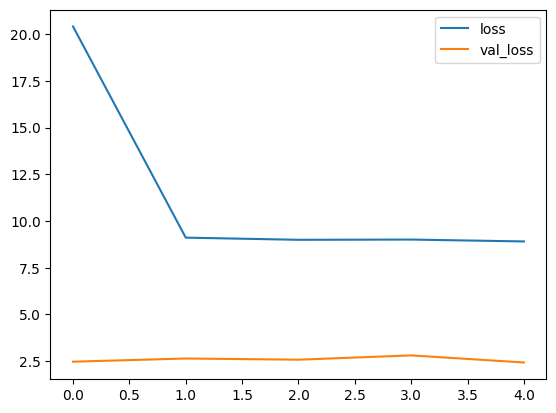

In [18]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

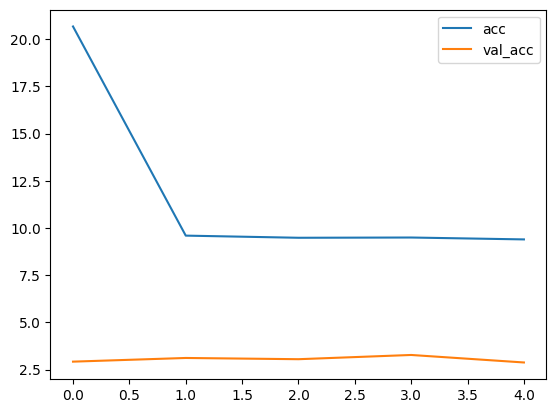

In [20]:
plt.plot(r.history['mae'], label='acc')
plt.plot(r.history['val_mae'], label='val_acc')
plt.legend()
plt.show()